<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Перевод-текстов-в-векторы" data-toc-modified-id="Перевод-текстов-в-векторы-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Перевод текстов в векторы</a></span></li><li><span><a href="#Подбор-гиперпараметров-для-моделей-логистической-регрессии-и-градиентного-бустинга" data-toc-modified-id="Подбор-гиперпараметров-для-моделей-логистической-регрессии-и-градиентного-бустинга-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подбор гиперпараметров для моделей логистической регрессии и градиентного бустинга</a></span></li><li><span><a href="#Финальное-тестирование" data-toc-modified-id="Финальное-тестирование-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Финальное тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

## Подготовка

In [10]:
# !pip install matplotlib==3.8.0
# !pip install seaborn==0.13.0
# !pip install gdown
# !pip install optuna

In [2]:
import os
import warnings

import gdown
import matplotlib.pyplot as plt
import nltk
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import transformers
from catboost import CatBoostClassifier
from IPython.display import HTML, display
from joblib import Parallel, delayed
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression        
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     train_test_split)
from torch.utils.data import DataLoader, Dataset
from tqdm import notebook
from transformers import AutoModel, AutoTokenizer

In [3]:
SEED = 12345

display(HTML('<style>.container { width:90% !important; }</style>'))
nltk.download('stopwords')
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('darkgrid')
stopwords = list(set(nltk_stopwords.words('english')))
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def get_df(file_name, idx=[0]):
    path_to_file = os.path.relpath(os.path.join('datasets/', file_name))
    if os.path.isfile(path_to_file):
        return pd.read_csv(path_to_file, index_col=idx)
    raise Exception('Данные отсутствуют')

In [5]:
df = get_df('toxic_comments.csv')

True


In [6]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


In [7]:
df['text'].duplicated().sum()

0

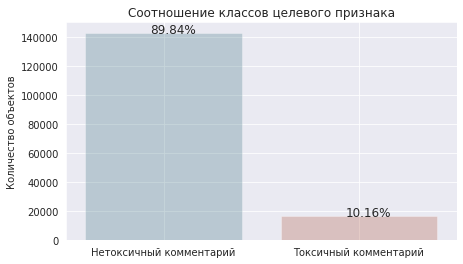

In [8]:
temp = df.pivot_table(index='toxic', values='text',
                      aggfunc='count', margins=True)
temp.columns = ['count']
temp['percentage'] = temp.apply(
    lambda x: (x.values / temp.loc['All', 'count'] * 100).round(2)
)
temp = temp.drop('All', axis=0)

plt.figure(figsize=(7, 4))
pal = sns.diverging_palette(220, 20, as_cmap=True).reversed()
ax = sns.barplot(data=temp, x=temp.index, y='count', palette=pal,
                 hue='count', dodge=False, alpha=.3)

patches = ax.patches[1::-1]
for item, value in zip(patches, temp['percentage']):
    plt.annotate(f'{value}%',
                 (item.get_x() + item.get_width() / 2.4, item.get_height()),
                 fontsize=12)

plt.xticks([0, 1], ['Нетоксичный комментарий', 'Токсичный комментарий'])
ax.set_xlabel('')
ax.set_ylabel('Количество объектов')
ax.set_title('Соотношение классов целевого признака')
ax.get_legend().remove()
ax.grid(True)

**Вывод**:  
- загруженный набор данных состоит из 159292 объектов;  
- пропуски и явные дубликаты отсутствуют;  
- классы целевого признака не сбалансированы.

## Обучение

### Предобработка данных

Избавимся от лишних символов и стоп-слов.

In [9]:
%%time
df['text'] = df['text'].str.replace(r'\n+', ' ', regex=True)
df['text'] = df['text'].str.replace(
    r'[^a-z\.\!\?\s\']', ' ', case=False, regex=True
)

CPU times: user 3.5 s, sys: 41.1 ms, total: 3.54 s
Wall time: 3.55 s


In [10]:
%%time
to_remove = ' | '.join(stopwords)
to_remove = ' ' + to_remove + ' '
df['text'] = \
    df['text'].str.replace(to_remove, ' ', case=False, regex=True)

CPU times: user 24 s, sys: 6.97 ms, total: 24 s
Wall time: 24 s


In [11]:
%%time
df['text'] = df['text'].str.replace(r'^[^a-z]', ' ', case=False, regex=True)
df['text'] = \
    df['text'].str.replace(r'\. (?![A-Z])', ' ', case=True, regex=True)
df['text'] = df['text'].replace(r'\s{2,}', ' ', regex=True)
df['text'] = df['text'].str.strip()

CPU times: user 3.03 s, sys: 7.82 ms, total: 3.03 s
Wall time: 3.05 s


### Перевод текстов в векторы

In [12]:
# model_path = 'unitary/toxic-bert'
# model = AutoModel.from_pretrained(model_path)
# tokenizer = AutoTokenizer.from_pretrained(model_path)

In [13]:
# %%time
# encoded = tokenizer.batch_encode_plus(
#     df['text'].to_list(), add_special_tokens=True,
#     return_attention_mask=True, padding='max_length', truncation=True,
#     return_token_type_ids=False, max_length=100, return_tensors='pt'
# )

In [14]:
# padded, attention_mask = encoded.values()

In [15]:
# batch_size = 200

# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, data, attention_mask):
#         self.data = data
#         self.attention_mask = attention_mask

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.attention_mask[idx]


# dataset = CustomDataset(padded, attention_mask)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


# def process_batch(batch):
#     batch, attention_mask_batch = batch
#     with torch.no_grad():
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#     return batch_embeddings[0][:, 0, :].cpu().numpy()

In [16]:
# %%time
# embeddings = Parallel(n_jobs=-1, backend='threading')(
#     delayed(process_batch)(batch)
#     for batch in notebook.tqdm(dataloader)
# )

In [17]:
# features = np.concatenate(embeddings)
# np.save('embeddings_100', features)

In [18]:
def get_embeddings(file_name):
    path_to_file = os.path.relpath(os.path.join(file_name))
    if os.path.isfile(path_to_file):
        return np.load(file_name)
    url = 'https://drive.google.com/uc?id=1gIhDHfgGqeut5Ztws_moW8PZ2Vgr1ftl'
    gdown.download(url, file_name, quiet=False)
    return np.load(file_name)

In [19]:
features = get_embeddings('embeddings_100.npy')
target = df['toxic']

### Подбор гиперпараметров для моделей логистической регрессии и градиентного бустинга

In [20]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=.2,
                     stratify=target, random_state=SEED)

In [21]:
features_train_, _, target_train_, _ = \
    train_test_split(features_train, target_train, test_size=.9,
                     stratify=target_train, random_state=SEED)

In [22]:
def objective(trial, X_train, y_train, classifier='cat'):
    if classifier == 'cat':
        params = {
            'colsample_bylevel': trial.suggest_float(
                'colsample_bylevel', 0.01, 1
            ),
            'depth': trial.suggest_int('depth', 2, 7),
            'boosting_type': trial.suggest_categorical(
                'boosting_type', ['Ordered', 'Plain']
            ),
            'bootstrap_type': trial.suggest_categorical(
                'bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']
            ),
            'used_ram_limit': '3gb'
        }

        if params['bootstrap_type'] == 'Bayesian':
            params['bagging_temperature'] = trial.suggest_float(
                'bagging_temperature', 0, 10
            )
        elif params['bootstrap_type'] == 'Bernoulli':
            params['subsample'] = trial.suggest_float('subsample', 0.1, 1)

        clf = CatBoostClassifier(
            **params, silent=True, random_state=SEED, thread_count=-1
        )
    else:
        lr_params = {
            'C': trial.suggest_float('C', 0.6, 0.8),
            'max_iter': trial.suggest_int('max_iter', 100, 3000),
            'solver': trial.suggest_categorical(
                'solver', ['lbfgs', 'liblinear', 'sag', 'saga']
            ),
            'intercept_scaling': trial.suggest_int(
                'intercept_scaling', 50, 70
            ),
            'tol': trial.suggest_float('tol', 0.2, 0.25)
        }
        clf = LogisticRegression(n_jobs=-1, random_state=SEED, **lr_params)

    return cross_val_score(
        clf, X_train, y_train, scoring='f1', n_jobs=-1,
        cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
    ).mean()

In [23]:
# func = lambda trial: objective(trial, features_train_, target_train_,
#                                classifier='lr')
# sampler = optuna.samplers.TPESampler(seed=SEED)
# lr_study = optuna.create_study(direction='maximize', sampler=sampler)
# lr_study.optimize(func, n_trials=10, show_progress_bar=True)

In [24]:
# func = lambda trial: objective(trial, features_train_, target_train_)
# sampler = optuna.samplers.TPESampler(seed=SEED)
# cat_study = optuna.create_study(direction='maximize', sampler=sampler)
# cat_study.optimize(func, n_trials=30, show_progress_bar=True)

In [25]:
# lr_params = lr_study.best_params
# cat_params = cat_study.best_params

lr_params = {
    'C': 0.7859232185634296,
    'max_iter': 1017,
    'solver': 'saga',
    'intercept_scaling': 70,
    'tol': 0.23265885484357854
}

cat_params = {
    'colsample_bylevel': 0.7309835185238461,
    'depth': 6,
    'boosting_type': 'Plain',
    'bootstrap_type': 'MVS'
}

In [26]:
%%time
lr_model = LogisticRegression(random_state=SEED, n_jobs=-1, **lr_params)

lr_result = cross_validate(
    lr_model, features_train_, target_train_, n_jobs=-1,
    scoring=['f1', 'roc_auc'], error_score='raise',
    cv=StratifiedKFold(5, random_state=SEED, shuffle=True),
)

CPU times: user 2.01 s, sys: 401 ms, total: 2.41 s
Wall time: 2.39 s


In [27]:
cv_results = []
cv_results.append(
    [lr_result['test_f1'].mean(), lr_result['test_roc_auc'].mean(),
     lr_result['fit_time'].mean()]
)

In [28]:
# %%time
# cat_model = CatBoostClassifier(
#     silent=True, **cat_params, random_state=SEED, thread_count=-1
# )
# cat_result = cross_validate(
#     cat_model, features_train_, target_train_, n_jobs=-1,
#     scoring=['f1', 'roc_auc'], error_score='raise',
#     cv=StratifiedKFold(5, random_state=SEED, shuffle=True),
# )

In [29]:
cat_result = {}
cat_result['test_f1'] = \
    np.array([0.89387755, 0.89788054, 0.89788054, 0.88188976, 0.89938398])
cat_result['test_roc_auc'] = \
    np.array([0.99416803, 0.99163224, 0.99449343, 0.99081557, 0.99439994])
cat_result['fit_time'] = \
    np.array([304.05780268, 305.87503767, 300.88471246, 300.69109964, 299.94534755])

cv_results.append(
    [cat_result['test_f1'].mean(), cat_result['test_roc_auc'].mean(),
     cat_result['fit_time'].mean()]
)

In [30]:
ids = ['Среднее значение метрики F1', 'Среднее значение метрики ROC_AUC',
       'Среднее время обучения (секунды)']
model_results = {
    'LogisticRegression': cv_results[0],
    'CatBoostClassifier': cv_results[1]
}
pd.DataFrame(
    data=model_results,
    index=ids
).round(2)

,LogisticRegression,CatBoostClassifier
Среднее значение метрики F1,0.89,0.89
Среднее значение метрики ROC_AUC,0.99,0.99
Среднее время обучения (секунды),0.46,302.29


Рассмотренные модели на кросс-валидации продемонстрировали примерно равные результаты, при этом модель логистической регрессии обучается значительно быстрее градиентного бустинга. Поэтому для финального тестирования выберем модель логистической регрессии.

### Финальное тестирование

In [31]:
# %%time
# model = LogisticRegression(random_state=SEED, n_jobs=-1, **lr_params)
# model.fit(features_train, target_train)
# predicted = model.predict(features_test)

In [32]:
%%time
model = LogisticRegression(random_state=SEED, n_jobs=-1, **lr_params)
model.fit(features_train, target_train)
predicted = model.predict(features_test)

CPU times: user 3.8 s, sys: 23.8 ms, total: 3.83 s
Wall time: 3.79 s


In [33]:
def plot_roc_curve(roc_auc, probs, X_test=features_test,
                   y_test=target_test, threshold=.5):
    fpr, tpr, thresh = roc_curve(y_test, probs)

    idx = np.argmin(abs(thresh - threshold))
    x_thresh, y_thresh = fpr[idx], tpr[idx]

    plt.figure(figsize=(7, 5))
    
    plt.plot(fpr, tpr, label=f'ROC-кривая (площадь = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], c='r', linestyle='--', label='Случайная модель')

    plt.axhline(y=y_thresh, c='black', ls=':')
    plt.axvline(x=x_thresh, c='black', ls=':')
    
    plt.text(x=.05, y=.92, s=f'Порог : {threshold:.2f}')
    plt.plot(x_thresh, y_thresh, 'ro')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()

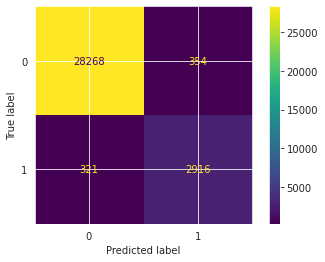

In [34]:
matrix = confusion_matrix(target_test, predicted)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot();

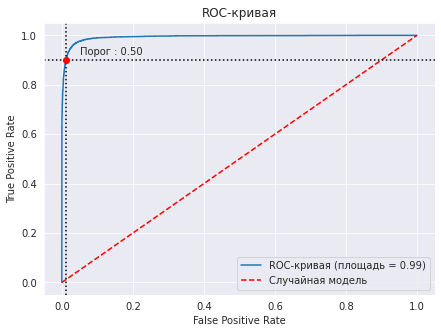

In [35]:
probs = model.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, probs)
plot_roc_curve(roc_auc, probs)

In [36]:
print(classification_report(target_test, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28622
           1       0.89      0.90      0.90      3237

    accuracy                           0.98     31859
   macro avg       0.94      0.94      0.94     31859
weighted avg       0.98      0.98      0.98     31859



## Выводы

**Описание данных**   
`text` — текст комментария  
`toxic` — целевой признак.  

**Ход исследования**:  
- загружен набор данных, состоящий из 159292 объектов;  
- в целевой переменной наблюдается дисбаланс классов;  
- пропуски и явные дубликаты не обнаружены;  
- данные очищены от лишних символов и стоп-слов;  
- датасет разделён на обучающую и тестовую выборки в соотношении 4:1;  
- с помощью модели `BERT` произведена токенизация и перевод текстов в векторы;  
- выполнен подбор гиперпараметров для моделей логистической регрессии и градиентного бустинга;  
- на кросс-валидации рассмотренные модели продемонстрировали примерно равные результаты, при этом модель логистической регрессии значительно превзошла градиентный бустинг по скорости обучения, поэтому была выбрана для финального тестирования;     
- результат на тестовой выборке: `F1` = 0.9.